<a href="https://colab.research.google.com/github/raviteja1432/NLP/blob/main/Copy_of_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 %%capture
!pip install tensorflow_text==2.6.0

In [ ]:
import os 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

from numpy import newaxis
from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

import xgboost as xgb
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Activation, GRU, BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
use = hub.load(module_url)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df_reviews = pd.read_csv("/content/drive/MyDrive/goodreads_train.csv")
df_reviews

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1
...,...,...,...,...,...,...,...,...,...,...,...
899995,b9450d1c1f97f891c392b1105959b56e,11832081,7c34c15ad8cb28a4afca32946e2016ea,3,3.5 stars. \n Jenna is a popular YA author and...,Fri Nov 16 22:10:17 -0800 2012,Sat Nov 17 22:42:44 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,0,0
899996,b9450d1c1f97f891c392b1105959b56e,16095092,e979c735276431915d089cfaf446d64f,3,This was a quick read for me. I have read a lo...,Fri Nov 16 22:09:49 -0800 2012,Sat Nov 17 23:38:58 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,1,1
899997,b9450d1c1f97f891c392b1105959b56e,8430896,feb9fe6439f9fbba8a1cce36020ad977,4,** spoiler alert ** \n 3.5 stars. \n This book...,Tue Nov 13 05:38:24 -0800 2012,Tue Nov 13 23:29:17 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,1,0
899998,b9450d1c1f97f891c392b1105959b56e,12275680,741e29369f70531bfffbd02add86f228,4,** spoiler alert ** \n Another fun read from M...,Mon Nov 12 05:42:30 -0800 2012,Tue Nov 13 22:32:05 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Mon Nov 12 00:00:00 -0800 2012,0,0


In [ ]:
df_reviews=df_reviews.drop(columns=['user_id', 'book_id','review_id' ,'date_added', 'date_updated', 'read_at', 'started_at','n_votes','n_comments'], axis=0)
df_reviews

,rating,review_text
0,5,This is a special book. It started slow for ab...
1,3,Recommended by Don Katz. Avail for free in Dec...
2,3,"A fun, fast paced science fiction thriller. I ..."
3,0,Recommended reading to understand what is goin...
4,4,"I really enjoyed this book, and there is a lot..."
...,...,...
899995,3,3.5 stars. \n Jenna is a popular YA author and...
899996,3,This was a quick read for me. I have read a lo...
899997,4,** spoiler alert ** \n 3.5 stars. \n This book...
899998,4,** spoiler alert ** \n Another fun read from M...


In [ ]:
df_reviews.drop(df_reviews.index[100000:900000], inplace=True)
df_reviews


,rating,review_text
0,5,This is a special book. It started slow for ab...
1,3,Recommended by Don Katz. Avail for free in Dec...
2,3,"A fun, fast paced science fiction thriller. I ..."
3,0,Recommended reading to understand what is goin...
4,4,"I really enjoyed this book, and there is a lot..."
...,...,...
99995,2,Underwhelming as hell. The characters were so ...
99996,4,This was so satisfying ugghhhh \n the characte...
99997,4,This was beautiful. Holy shit. I am absolute S...
99998,3,"I thought this was cute and, while it was love..."


In [ ]:
df_reviews["review_type"] = df_reviews["rating"].apply(
    lambda x: "very bad" if x == 0 else "bad" if x==1 else "good" if x==2 else "very good" if x==3 else "excelent")
df_reviews.rename(columns = {'review_text':'review'}, inplace = True)
df_reviews

,rating,review,review_type
0,5,This is a special book. It started slow for ab...,excelent
1,3,Recommended by Don Katz. Avail for free in Dec...,very good
2,3,"A fun, fast paced science fiction thriller. I ...",very good
3,0,Recommended reading to understand what is goin...,very bad
4,4,"I really enjoyed this book, and there is a lot...",excelent
...,...,...,...
99995,2,Underwhelming as hell. The characters were so ...,good
99996,4,This was so satisfying ugghhhh \n the characte...,excelent
99997,4,This was beautiful. Holy shit. I am absolute S...,excelent
99998,3,"I thought this was cute and, while it was love...",very good


In [ ]:
import re
df = df_reviews
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    text = text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    return(text)

data = df.copy()
data['review'] = data['review'].apply((lambda x: re.sub('RT ','',x)))
cleanedText = []
for text in data["review"].values:
    text = text+" "
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'(@){1}.+?( ){1}', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'(#){1}.+?( ){1}', ' ', text, flags=re.MULTILINE)
    cleanedText.append(text_to_wordlist(text))
data['cleanedText'] = cleanedText

data.head(15)


,rating,review,review_type,cleanedText
0,5,This is a special book. It started slow for ab...,excelent,this is a special book it started slow for abo...
1,3,Recommended by Don Katz. Avail for free in Dec...,very good,recommended by don katz avail for free in dece...
2,3,"A fun, fast paced science fiction thriller. I ...",very good,a fun fast paced science fiction thriller i re...
3,0,Recommended reading to understand what is goin...,very bad,recommended reading to understand what is goin...
4,4,"I really enjoyed this book, and there is a lot...",excelent,i really enjoyed this book and there is a lot ...
5,4,A beautiful story. It is rare to encounter a b...,excelent,a beautiful story it is rare to encounter a bo...
6,5,5 stars for giving me a better framework for h...,excelent,5 stars for giving me a better framework for h...
7,0,Numerous people in publishing have told me thi...,very bad,numerous people in publishing have told me thi...
8,4,Another hard to put down nonfiction book from ...,excelent,another hard to put down nonfiction book from ...
9,5,I love Stephenson - and this was another hit -...,excelent,i love stephenson - and this was another hit -...


In [ ]:
data.drop(columns=['review'],axis=1, inplace=True)
data.rename(columns = {'cleanedText':'review'}, inplace = True)
df_reviews = data
df_reviews

,rating,review_type,review
0,5,excelent,this is a special book it started slow for abo...
1,3,very good,recommended by don katz avail for free in dece...
2,3,very good,a fun fast paced science fiction thriller i re...
3,0,very bad,recommended reading to understand what is goin...
4,4,excelent,i really enjoyed this book and there is a lot ...
...,...,...,...
99995,2,good,underwhelming as hell the characters were so b...
99996,4,excelent,this was so satisfying ugghhhh the character d...
99997,4,excelent,this was beautiful holy shit i am absolute sno...
99998,3,very good,i thought this was cute and while it was lovel...


In [ ]:
fig = px.histogram(df_reviews, x="review_type", title='how good the book is', text_auto=True)
fig.show()

In [ ]:
excelent_reviews = df_reviews[df_reviews.review_type == "excelent"]
very_good_reviews = df_reviews[df_reviews.review_type == "very good"]
good_reviews = df_reviews[df_reviews.review_type == "good"]
bad_reviews = df_reviews[df_reviews.review_type == "bad"]
very_bad_reviews = df_reviews[df_reviews.review_type == "very_bad"]

In [ ]:
excelent_reviews_text = " ".join(excelent_reviews.review.to_numpy().tolist())
very_good_reviews_text = " ".join(very_good_reviews.review.to_numpy().tolist())
good_reviews_text = " ".join(good_reviews.review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.review.to_numpy().tolist())
very_bad_reviews_text = " ".join(very_bad_reviews.review.to_numpy().tolist())

In [ ]:
excelent_df = excelent_reviews.sample(n=len(very_good_reviews)+len(good_reviews)+len(bad_reviews)+len(very_bad_reviews), random_state=RANDOM_SEED, replace=True)

excelent_df = excelent_df.append(very_good_reviews).reset_index(drop=True)
excelent_df = excelent_df.append(good_reviews).reset_index(drop=True)
excelent_df = excelent_df.append(bad_reviews).reset_index(drop=True)
df_review_resampled = excelent_df.append(very_bad_reviews).reset_index(drop=True)
#df_review_resampled = excelent_df.extend(very_good_reviews,good_reviews,bad_reviews,very_bad_reviews).reset_index(drop=True)
df_review_resampled.shape

(62484, 3)

In [ ]:
df_review_resampled

,rating,review_type,review
0,5,excelent,wow what is there to say about clockwork princ...
1,4,excelent,spoiler alert i loved this book conceptually ...
2,4,excelent,this was my first book by kay and i have been ...
3,4,excelent,have you ever wanted something so badly that ...
4,5,excelent,wow - wow - wow that ending ! i was bawling my...
...,...,...,...
62479,1,bad,yeah i guess there something to be said about ...
62480,1,bad,you know i totally liked this book up until th...
62481,1,bad,a friend of mine recommended this book to me y...
62482,1,bad,i had already given up reading jane austen fan...


In [ ]:
label_enc = preprocessing.LabelEncoder()
encoded_review = label_enc.fit_transform(df_review_resampled.review_type.values)

In [ ]:
train_reviews, test_reviews, y_train, y_test = train_test_split(
    df_review_resampled.review, 
    encoded_review, 
    test_size=0.25, 
    random_state=RANDOM_SEED
  )

In [ ]:
X_train = []
for r in tqdm(train_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 46863/46863 [20:24<00:00, 38.26it/s]


In [ ]:
X_test = []
for r in tqdm(test_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 15621/15621 [06:46<00:00, 38.41it/s]


In [ ]:
print(X_train.shape, X_test.shape)

(46863, 512) (15621, 512)


In [ ]:
print(y_train.shape, y_test.shape)

(46863,) (15621,)


In [ ]:
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy= history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot_model(model):
    model.summary()
    return tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    )

In [ ]:
y_train.shape

(46863,)

In [ ]:
X_train_reshaped = X_train[:, newaxis,:]
X_test_reshaped = X_test[:, newaxis,:]

In [ ]:
X_train_reshaped.shape

(46863, 1, 512)

In [ ]:
# input_shape
1,X_train_reshaped.shape[2]

(1, 512)

In [ ]:
def build_model_lstm():
    model = Sequential()
    model.add(LSTM(512, activation='sigmoid', return_sequences=True,
                 input_shape=(1,X_train_reshaped.shape[2])
                 ))
   # model.add(SpatialDropout1D(0.2))
    #model.add(LSTM(256, dropout=0.2))
    #model.add(LSTM(128, dropout=0.2))
    model.add(LSTM(256, dropout=0.2, activation='sigmoid', return_sequences=True))
    model.add(LSTM(128, dropout=0.2, activation='sigmoid', return_sequences=True))
    model.add(Dense(34, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
    return model

In [ ]:
model_lstm = build_model_lstm()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1, 512)            2099200   
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 256)            787456    
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 128)            197120    
_________________________________________________________________
dense_9 (Dense)              (None, 1, 34)             4386      
_________________________________________________________________
dense_10 (Dense)             (None, 1, 32)             1120      
_________________________________________________________________
dense_11 (Dense)             (None, 1, 5)              165       
Total params: 3,089,447
Trainable params: 3,089,447
Non-trainable params: 0
____________________________________________

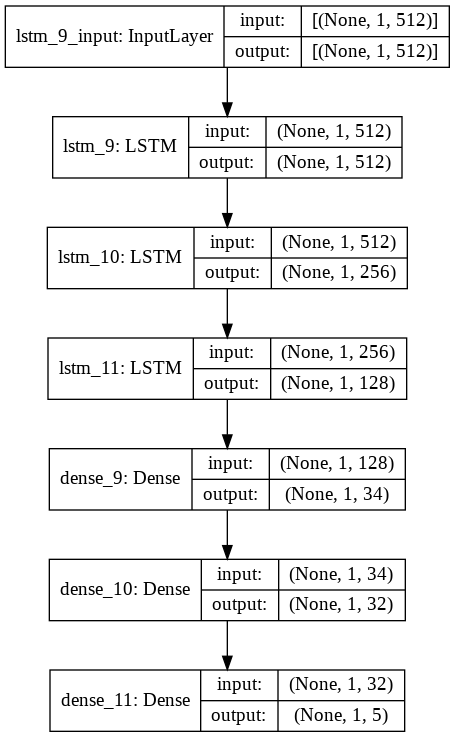

In [ ]:
plot_model(model_lstm)

In [ ]:
%%time
history = model_lstm.fit(
    X_train_reshaped, y_train, 
    epochs=30, 
    batch_size=10, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/30
4218/4218 [==============================] - 69s 16ms/step - loss: 0.8493 - accuracy: 0.6239 - val_loss: 0.8673 - val_accuracy: 0.6213
Epoch 2/30
4218/4218 [==============================] - 65s 15ms/step - loss: 0.8482 - accuracy: 0.6244 - val_loss: 0.8664 - val_accuracy: 0.6187
Epoch 3/30
4218/4218 [==============================] - 65s 15ms/step - loss: 0.8461 - accuracy: 0.6267 - val_loss: 0.8656 - val_accuracy: 0.6260
Epoch 4/30
4218/4218 [==============================] - 69s 16ms/step - loss: 0.8438 - accuracy: 0.6310 - val_loss: 0.8611 - val_accuracy: 0.6241
Epoch 5/30
4218/4218 [==============================] - 65s 15ms/step - loss: 0.8417 - accuracy: 0.6291 - val_loss: 0.8598 - val_accuracy: 0.6241
Epoch 6/30
4218/4218 [==============================] - 70s 17ms/step - loss: 0.8390 - accuracy: 0.6316 - val_loss: 0.8607 - val_accuracy: 0.6217
Epoch 7/30
4218/4218 [==============================] - 66s 16ms/step - loss: 0.8376 - accuracy: 0.6303 - val_loss: 0.8612 -

In [ ]:
model_lstm.evaluate(X_test_reshaped, y_test)

489/489 [==============================] - 2s 4ms/step - loss: 0.8384 - accuracy: 0.6311


[0.8384013772010803, 0.6311375498771667]

In [ ]:
model_lstm.save("lstm_sentiment_model9.h5")
model_lstm.save("/content/drive/MyDrive/lstm_sentiment_model9.h5")